In [5]:
!pip install opencv-python-headless

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

print("OpenCV version:", cv2.__version__)

OpenCV version: 4.10.0


Original image shape: (1000, 2000)


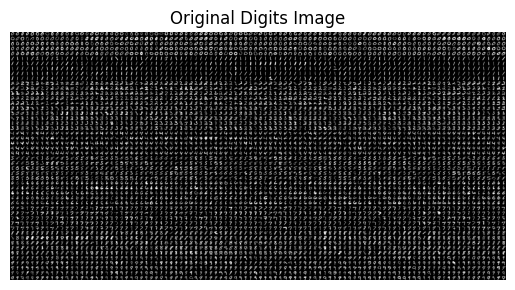

Training data saved as 'trained_opencv.npz'!


In [7]:
url = 'https://raw.githubusercontent.com/npinto/opencv/master/samples/python2/data/digits.png'
ouput_file = 'digits.png'
os.system(f'wget -O {ouput_file} {url}')

img_digits = cv2.imread(ouput_file, cv2.IMREAD_GRAYSCALE)
if img_digits is None:
    print("digits.png를 불러올 수 없습니다.")
else:
  print(f'Original image shape: {img_digits.shape}')
  plt.imshow(img_digits, cmap='gray')
  plt.title('Original Digits Image')
  plt.axis('off')
  plt.show()

  cells = [np.hsplit(row, 100) for row in np.vsplit(img_digits, 50)]
  x = np.array(cells)

  train = x.reshape(-1, 400).astype(np.float32)

  k = np.arange(10)
  train_labels = np.repeat(k, 500)[:, np.newaxis]

  np.savez('trained_opencv.npz', train=train, train_labels=train_labels)
  print("Training data saved as 'trained_opencv.npz'!")

In [8]:
def preprocess_image_colab(image_path):
    """
    테스트 이미지(예: 숫자 1장) 전처리:
    1) GRAYSCALE 로드
    2) 이진화
    3) 외곽선 표시 (시각화용)
    4) 20x20 크기로 리사이즈
    5) 1x400 형태로 벡터화 (float32)
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)

    resized = cv2.resize(binary, (20, 20))

    print("[Original Grayscale]")
    cv2_imshow(img)

    print("[Binary Inverted]")
    cv2_imshow(binary)

    print("[Contours Drawn]")
    cv2_imshow(img_with_contours)

    print("[Resized 20x20]")
    cv2_imshow(resized)

    vector_400 = resized.reshape(-1, 400).astype(np.float32)
    return vector_400

In [9]:
def knn_train_and_test_colab(train_data, train_labels, test_image_path, k=3):
    knn = cv2.ml.KNearest_create()

    knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

    test_vector = preprocess_image_colab(test_image_path)

    ret, results, neighbours, dist = knn.findNearest(test_vector, k)
    predicted_label = int(results[0, 0])

    print(f'Predicted Label: {predicted_label}')
    print(f'Neighbours: {neighbours}')
    print(f'Distance: {dist}')

    return predicted_label, neighbours, dist

In [11]:
train_data = None
train_labels = None
try:
  with np.load('trained_opencv.npz') as data:
    train_data = data['train']
    train_labels = data['train_labels']
  print(f'train_data shape = {train_data.shape}, train_labels shape = {train_labels.shape}')
except FileNotFoundError:
  print("trained_opencv.npz 파일이 존재하지 않습니다. 앞 셀을 실행해주세요.")

train_data shape = (5000, 400), train_labels shape = (5000, 1)


[Original Grayscale]


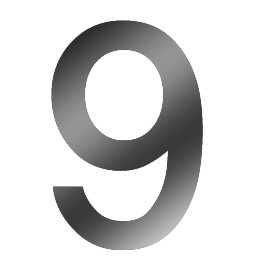

[Binary Inverted]


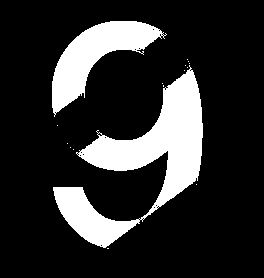

[Contours Drawn]


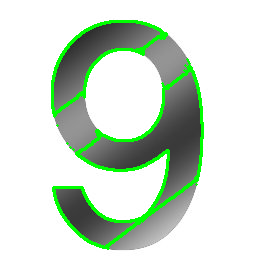

[Resized 20x20]


Predicted Label: 2
Neighbours: [[2. 2. 2. 2. 3.]]
Distance: [[2689415. 2746399. 2748626. 2749337. 2827029.]]


In [47]:
#test_image_path = 'test_digit_3.png'
test_image_path = '9.jpg'

pred_label, neighbors, distances = None, None, None
if train_data is not None and train_labels is not None:
  pred_label, neighbors, distances = knn_train_and_test_colab(
      train_data, train_labels, test_image_path, k=5
  )

In [48]:
def visualize_result_colab(image_path, predicted_label):
  img = cv2.imread(image_path)
  if img is None:
    raise ValueError(f"Image not found at {image_path}")

  output = img.copy()
  text = f'Predicted: {predicted_label}'
  cv2.putText(
      output, text, (10, 50),
      cv2.FONT_HERSHEY_SIMPLEX, 1,
       (0, 255, 0), 2
  )

  print('[Test Image with Prediction]')
  cv2_imshow(output)

[Test Image with Prediction]


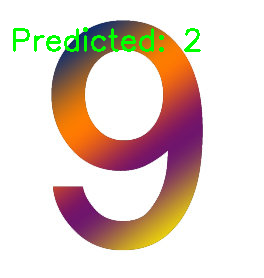

In [49]:
if pred_label is not None:
  visualize_result_colab(test_image_path, pred_label)

Testing with K=1
Predicted Label: 9
Neighbours: [[9.]]
Distance: [[2097715.]]
[Test Image with Prediction]


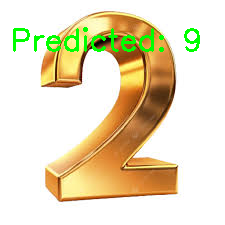

Testing with K=3
Predicted Label: 2
Neighbours: [[9. 6. 2.]]
Distance: [[2097715. 2158174. 2208670.]]
[Test Image with Prediction]


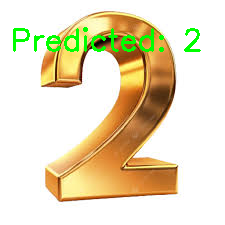

Testing with K=5
Predicted Label: 2
Neighbours: [[9. 6. 2. 7. 2.]]
Distance: [[2097715. 2158174. 2208670. 2223742. 2234627.]]
[Test Image with Prediction]


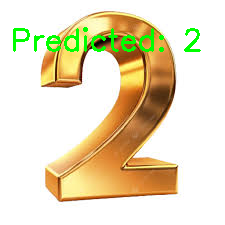

Testing with K=7
Predicted Label: 9
Neighbours: [[9. 6. 2. 7. 2. 9. 9.]]
Distance: [[2097715. 2158174. 2208670. 2223742. 2234627. 2239635. 2248997.]]
[Test Image with Prediction]


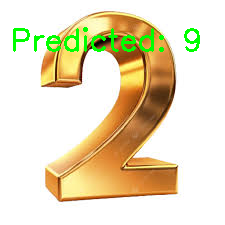

Testing with K=9
Predicted Label: 9
Neighbours: [[9. 6. 2. 7. 2. 9. 9. 7. 8.]]
Distance: [[2097715. 2158174. 2208670. 2223742. 2234627. 2239635. 2248997. 2259457.
  2259551.]]
[Test Image with Prediction]


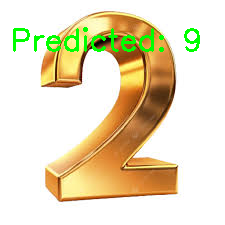

In [64]:
k_values = [1, 3, 5, 7, 9]
for k in k_values:
    print(f"Testing with K={k}")
    pred_label, neighbors, distances = knn_train_and_test_colab(train_data, train_labels, test_image_path, k)
    visualize_result_colab(test_image_path, pred_label)

In [65]:
threshold_methods = [
    ("THRESH_BINARY", cv2.THRESH_BINARY),
    ("THRESH_BINARY_INV", cv2.THRESH_BINARY_INV),
    ("THRESH_OTSU", cv2.THRESH_OTSU)
]

for method_name, method in threshold_methods:
    print(f"Testing with thresholding method: {method_name}")

    def preprocess_image_threshold(image_path, threshold_method):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found at {image_path}")

        _, binary = cv2.threshold(img, 128, 255, threshold_method)
        resized = cv2.resize(binary, (20, 20))
        vector_400 = resized.reshape(-1, 400).astype(np.float32)

        print(f"[Processed with {method_name}]")
        cv2_imshow(resized)

        return vector_400

    test_vector = preprocess_image_threshold(test_image_path, method)
    pred_label, neighbors, distances = knn_train_and_test_colab(train_data, train_labels, test_image_path, 3)


Testing with thresholding method: THRESH_BINARY
[Processed with THRESH_BINARY]


Predicted Label: 2
Neighbours: [[9. 6. 2.]]
Distance: [[2097715. 2158174. 2208670.]]
Testing with thresholding method: THRESH_BINARY_INV
[Processed with THRESH_BINARY_INV]


Predicted Label: 2
Neighbours: [[9. 6. 2.]]
Distance: [[2097715. 2158174. 2208670.]]
Testing with thresholding method: THRESH_OTSU
[Processed with THRESH_OTSU]


Predicted Label: 2
Neighbours: [[9. 6. 2.]]
Distance: [[2097715. 2158174. 2208670.]]


In [66]:
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)
_, svm_result = svm.predict(preprocess_image_colab(test_image_path))
print(f"SVM Predicted Label: {int(svm_result[0, 0])}")

SVM Predicted Label: 9


In [67]:
def extract_roi(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = img[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, (20, 20))
        cv2_imshow(roi_resized)
        return roi_resized.reshape(-1, 400).astype(np.float32)

roi_vector = extract_roi(test_image_path)
pred_label, neighbors, distances = knn_train_and_test_colab(train_data, train_labels, test_image_path, 3)

Predicted Label: 2
Neighbours: [[9. 6. 2.]]
Distance: [[2097715. 2158174. 2208670.]]


In [68]:
import time

start_time = time.time()
pred_label, neighbors, distances = knn_train_and_test_colab(train_data, train_labels, test_image_path, 3)
end_time = time.time()
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Predicted Label: 2
Neighbours: [[9. 6. 2.]]
Distance: [[2097715. 2158174. 2208670.]]
Execution Time: 0.0086 seconds


In [4]:
import numpy as np
import cv2
import time
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 1. 데이터 로드
try:
    with np.load('trained_opencv.npz') as data:
        train_data = data['train']
        train_labels = data['train_labels'].ravel()
except FileNotFoundError:
    print("trained_opencv.npz 파일이 없습니다.")
    exit()

# 2. K값 비교 함수
def compare_k_values(train_data, train_labels, test_data, test_labels):
    k_values = [1, 3, 5, 7, 9]
    results = {}

    for k in k_values:
        start_time = time.time()
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_data, train_labels)
        predictions = knn.predict(test_data)
        accuracy = accuracy_score(test_labels, predictions)
        execution_time = time.time() - start_time

        results[k] = {'accuracy': accuracy, 'time': execution_time}
        print(f"K={k}: 정확도={accuracy:.4f}, 실행시간={execution_time:.4f}초")

    return results

# 3. 전처리 함수
def preprocess_image(image):
    # OTSU 이진화
    _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 적응형 이진화
    adaptive_thresh = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)

    # 노이즈 제거
    denoised = cv2.GaussianBlur(image, (5,5), 0)

    return otsu_thresh, adaptive_thresh, denoised

# 4. ROI 추출 함수
def extract_rois(image):
    height, width = image.shape
    h_half, w_half = height // 2, width // 2

    rois = [
        image[0:h_half, 0:w_half],      # 좌상단
        image[0:h_half, w_half:width],   # 우상단
        image[h_half:height, 0:w_half],  # 좌하단
        image[h_half:height, w_half:width] # 우하단
    ]

    # 20x20 정규화
    normalized_rois = [cv2.resize(roi, (20, 20)) for roi in rois]
    return normalized_rois

# 5. 다양한 분류기 테스트 함수
def test_classifiers(train_data, train_labels, test_data, test_labels):
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_data, train_labels)
    knn_pred = knn.predict(test_data)
    knn_acc = accuracy_score(test_labels, knn_pred)

    # SVM
    svm = SVC(kernel='linear')
    svm.fit(train_data, train_labels)
    svm_pred = svm.predict(test_data)
    svm_acc = accuracy_score(test_labels, svm_pred)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(train_data, train_labels)
    rf_pred = rf.predict(test_data)
    rf_acc = accuracy_score(test_labels, rf_pred)

    return {'KNN': knn_acc, 'SVM': svm_acc, 'RandomForest': rf_acc}

# 메인 실행 코드
if __name__ == "__main__":
    # 테스트 이미지 로드
    test_image = cv2.imread('multiplt_test.png', cv2.IMREAD_GRAYSCALE)
    if test_image is None:
        print("테스트 이미지를 찾을 수 없습니다.")
        exit()

    # 전처리 적용
    otsu, adaptive, denoised = preprocess_image(test_image)

    # ROI 추출
    rois = extract_rois(denoised)

    # K값 비교
    k_results = compare_k_values(train_data, train_labels,
                               train_data[:100], train_labels[:100])

    # 다양한 분류기 테스트
    classifier_results = test_classifiers(train_data, train_labels,
                                        train_data[:100], train_labels[:100])

    # 결과 출력
    print("\n분류기 성능 비교:")
    for clf, acc in classifier_results.items():
        print(f"{clf}: {acc:.4f}")


K=1: 정확도=1.0000, 실행시간=0.0911초
K=3: 정확도=1.0000, 실행시간=0.1230초
K=5: 정확도=1.0000, 실행시간=0.0355초
K=7: 정확도=1.0000, 실행시간=0.0963초
K=9: 정확도=1.0000, 실행시간=0.0494초

분류기 성능 비교:
KNN: 1.0000
SVM: 1.0000
RandomForest: 1.0000
